# Self-Driving Car Engineer Nanodegree
## Deep Learning
# Project: Behavioral Cloning





### Training Data:
I first started by generating training data on my own and trying to train a model on it. After about 10 hours of fruitless effort, I realized that the data I created wasn't normally distributed due to the fact that I trained the model with keyboard input.
Once Udacity released their training data, I compared the distributions and the following is the output:

In [1]:
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import HTML,SVG
from moviepy.editor import ImageSequenceClip
from keras.models import model_from_json
from keras.utils.visualize_util import model_to_dot

%matplotlib inline

Using TensorFlow backend.


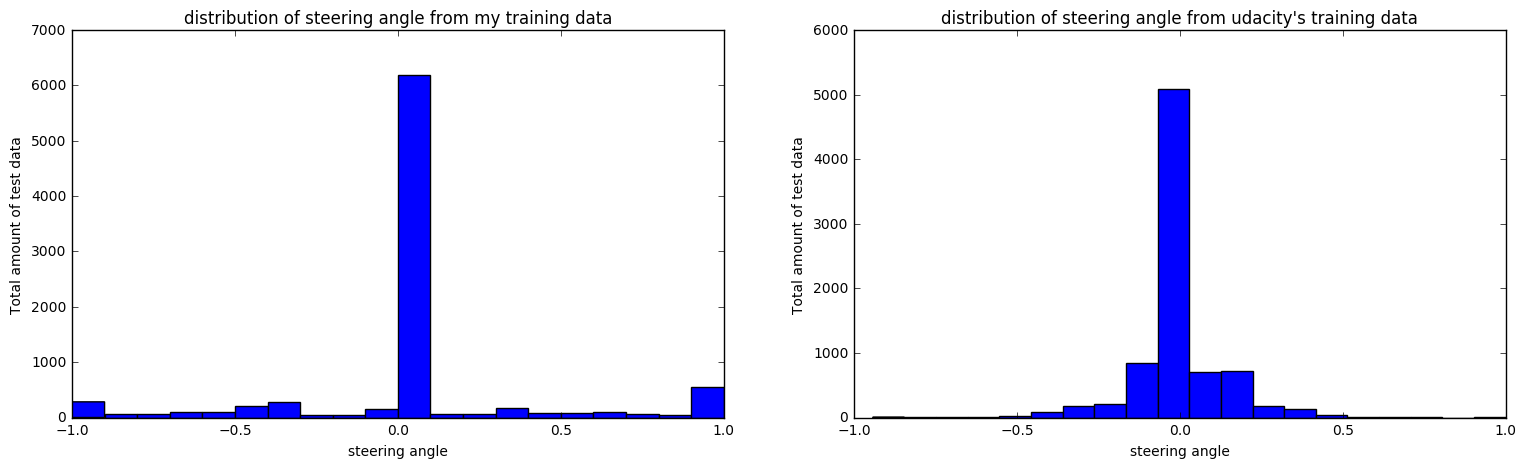

In [2]:
my_training_data = pd.read_csv('../driving_log.csv',names = ["center", "left", "right", "steering","throttle","break","speed"])
udacitys_training_data = pd.read_csv('driving_log.csv')
udacitys_training_data = udacitys_training_data[udacitys_training_data.center.str.startswith('IMG')]
plt.clf()
plt.subplot(1, 2, 1)
a = plt.hist(my_training_data.steering.tolist(),bins=20)
plt.title('distribution of steering angle from my training data')
plt.xlabel('steering angle')
plt.ylabel('Total amount of test data')
plt.subplot(1, 2, 2)
a = plt.hist(udacitys_training_data.steering.tolist(),bins=20)
plt.title("distribution of steering angle from udacity's training data")
plt.xlabel('steering angle')
plt.ylabel('Total amount of test data')
fig = plt.gcf().set_size_inches(18.5, 5, forward=True)
plt.show()

I obviously decided to use Udacity's training data for my model.

## Image processing

The goal of image processing was to remove unnecessary data from the image in order to let the model focus on relevant features, while keeping away from computer vision.

The images are processed in 3 steps:

1) Trimming the image - removing the top 40 pixels from the image since that is always clouds and trees.    
2) Resize the image to half its size.     
3) convert the image from RGB to YUV - converting it to YUV was the easiest way to remove unnecessary noise from the image.

Below is a sample of the image processing:

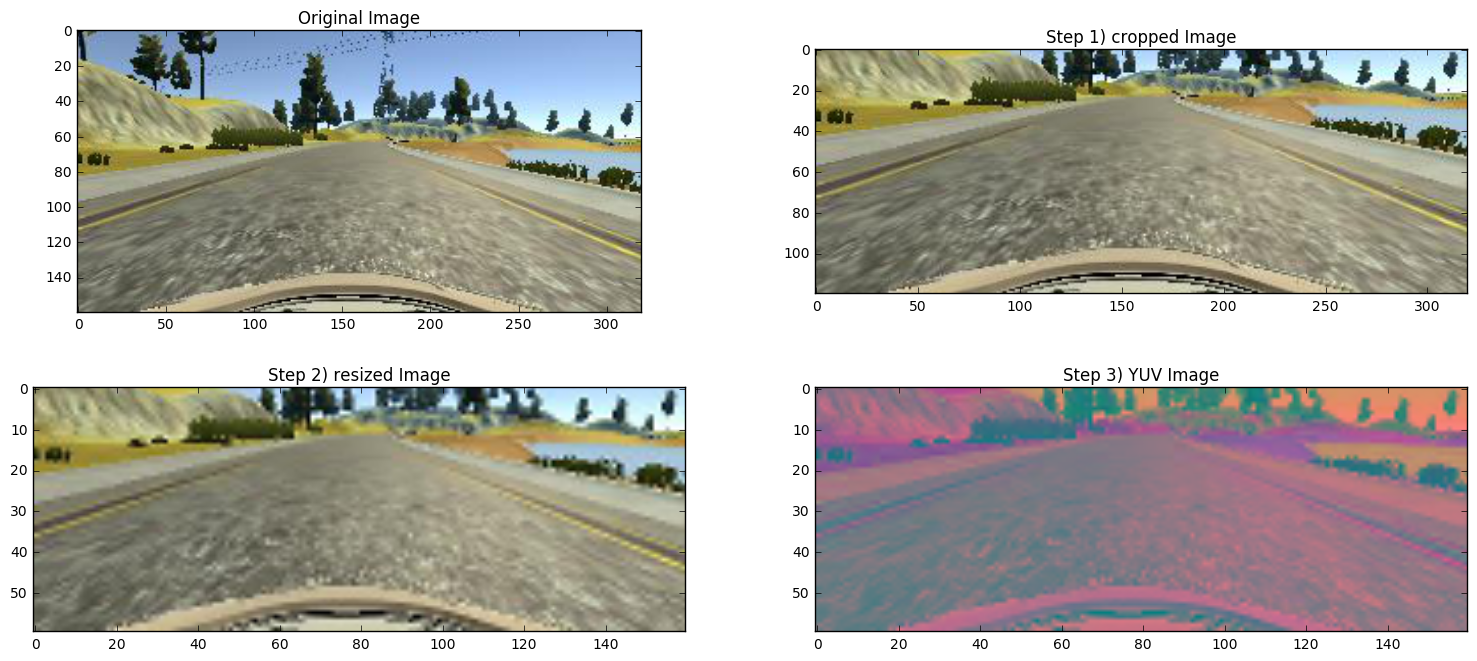

In [3]:
plt.clf()
fig = plt.figure()
a = fig.add_subplot(2,2,1)
img = mpimg.imread(udacitys_training_data.iloc[500].center)
imgplot = plt.imshow(img)
title = a.set_title('Original Image')
a = fig.add_subplot(2,2,2)
img = img[40:,:,:]
imgplot = plt.imshow(img)
title = a.set_title('Step 1) cropped Image')
a = fig.add_subplot(2,2,3)
img = cv2.resize(img,(160,60), interpolation = cv2.INTER_CUBIC)
imgplot = plt.imshow(img)
title = a.set_title('Step 2) resized Image')
a = fig.add_subplot(2,2,4)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
imgplot = plt.imshow(img)
title = a.set_title('Step 3) YUV Image')
fig = plt.gcf().set_size_inches(18.5, 8, forward=True)

## Recovery data

After training the model on the udacity's training data, My model performed well but had no means of recovery. I decided to add recovery data to the udacity training data.

Below is a video of the recovery data I added:

In [4]:
udacitys_training_data = pd.read_csv('driving_log.csv')
recovery_data = udacitys_training_data[ udacitys_training_data.center.str.startswith('C:')]['center']
video_file = 'recovery.mp4'
clip = ImageSequenceClip(recovery_data.tolist(), fps=23)
clip.to_videofile(video_file, fps=23)
HTML("""
<video width="320" height="160" controls>
  <source src="{0}">
</video>
""".format(video_file))

[MoviePy] >>>> Building video recovery.mp4
[MoviePy] Writing video recovery.mp4


100%|█████████████████████████████████████| 1210/1210 [00:08<00:00, 145.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: recovery.mp4 



## Network Architecture:

I started off using the NVIDIA network architecture described in [this paper](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) and revised it numerous times in order to get the desired output.


My final network architecture is as follows:

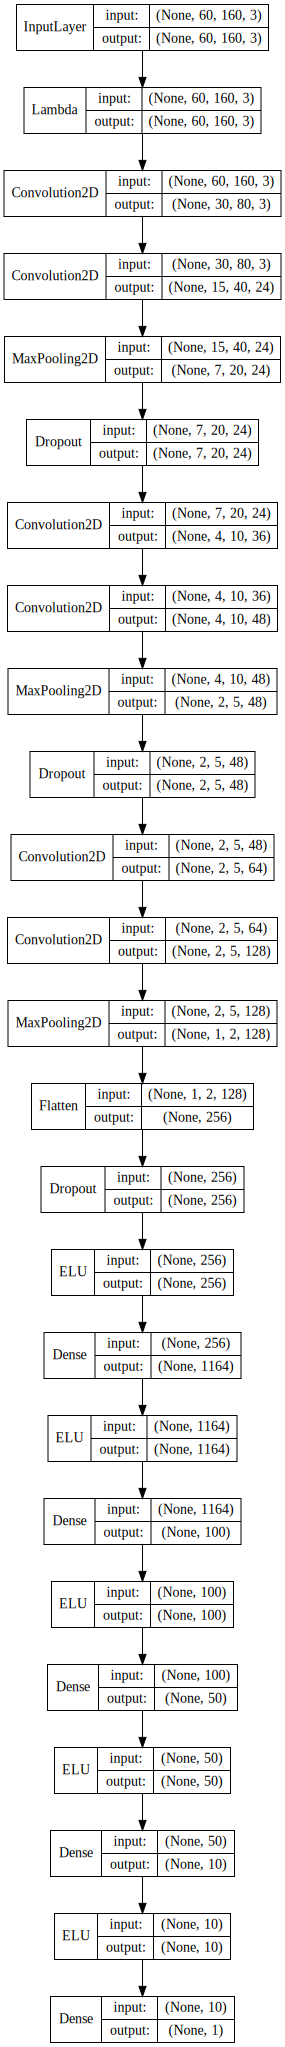

In [5]:
with open('model.json', 'r') as jfile:
    model = model_from_json(json.load(jfile))
SVG(model_to_dot(model, show_layer_names =False,show_shapes =True).create(prog='dot', format='svg'))


The layer's width is based off NVIDIA's model (1164 => 100 => 50 => 10).

I used ELU based off of a paper I read from [commaai]( https://github.com/commaai/research/blob/master/train_steering_model.py) why they used ELU in their steering angle prediction and I added some dropouts, convnets and maxpooling via fine tuning over multiple iterations.

The optimizer chosen for this model was the Adam optimizer. I played around with many different learning rates for the Adam optimizer and concluded that the default learning rate (0.001) was the most suitable for this problem.

My goal was to get the loss value of all datasets (train, validation, and test) below 0.025 and after 10 epoch's I finally got the desired output:

loss value on training data: 0.0230544453762 

loss value on validation data: 0.0211128074277 

loss value on test data: 0.0223111665767

